In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json as json
import requests
import os
import time
from sklearn import datasets, linear_model

In [522]:
import tweepy 

consumer_key = 'VZXuQcj4bDfe9FGOvA5H3FhfG'
consumer_secret = 'BaZUH6e83LKAEPzSNgHGChaMBHJ8Q9DDJuL8j2mooPiqpcHDaZ'
access_token = '1070493439706296320-GUZttIDj4AWLn0Or3lGS05xxK6kb3v'
access_secret = 'iAgr5898Fn73SS8yDq1wPxJC3AYBXZExHL8HKF5ZUrgLr'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit= True, wait_on_rate_limit_notify=True)

### Gather Data

1. The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

In [523]:
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [524]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'    
response = requests.get(url, auth=('user', 'pass'))


with open('image-predictions.tsv', 'wb') as file:
        file.write(response.content)

img_df = pd.read_csv('image-predictions.tsv',sep = '\t')
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [525]:
id_list = archive.tweet_id
error_list = []
df_tweet_info = []
count = 0

#clear the file before start writing 
if os.path.exists('tweet_json.txt'):
    os.remove('tweet_json.txt')

start = time.time()
for tweet_id in id_list:
    try: 
    # write the code here
        count = count + 1
        tweet = api.get_status(tweet_id,tweet_mode='extended')
        print('{0}. {1}'.format(count, tweet_id))
        df_tweet_info.append(tweet._json)
          
    except tweepy.TweepError:
        print("Can't find the Tweet ID:{}".format(tweet_id))
        error_list.append(tweet_id)
        
with open('tweet_json.txt', 'a',encoding = 'utf-8') as file:
    file.write('\n'.join(json.dumps(t) for t in df_tweet_info))        

end = time.time()
print (end - start)



1. 892420643555336193
2. 892177421306343426
3. 891815181378084864
4. 891689557279858688
5. 891327558926688256
6. 891087950875897856
7. 890971913173991426
8. 890729181411237888
9. 890609185150312448
10. 890240255349198849
11. 890006608113172480
12. 889880896479866881
13. 889665388333682689
14. 889638837579907072
15. 889531135344209921
16. 889278841981685760
17. 888917238123831296
18. 888804989199671297
19. 888554962724278272
Can't find the Tweet ID:888202515573088257
21. 888078434458587136
22. 887705289381826560
23. 887517139158093824
24. 887473957103951883
25. 887343217045368832
26. 887101392804085760
27. 886983233522544640
28. 886736880519319552
29. 886680336477933568
30. 886366144734445568
31. 886267009285017600
32. 886258384151887873
33. 886054160059072513
34. 885984800019947520
35. 885528943205470208
36. 885518971528720385
37. 885311592912609280
38. 885167619883638784
39. 884925521741709313
40. 884876753390489601
41. 884562892145688576
42. 884441805382717440
43. 884247878851493888


335. 832682457690300417
336. 832645525019123713
337. 832636094638288896
338. 832397543355072512
339. 832369877331693569
340. 832273440279240704
341. 832215909146226688
342. 832215726631055365
343. 832088576586297345
344. 832040443403784192
345. 832032802820481025
346. 831939777352105988
347. 831926988323639298
348. 831911600680497154
349. 831670449226514432
350. 831650051525054464
351. 831552930092285952
352. 831322785565769729
353. 831315979191906304
354. 831309418084069378
355. 831262627380748289
356. 830956169170665475
357. 830583320585068544
358. 830173239259324417
359. 830097400375152640
360. 829878982036299777
361. 829861396166877184
362. 829501995190984704
363. 829449946868879360
Can't find the Tweet ID:829374341691346946
365. 829141528400556032
366. 829011960981237760
367. 828801551087042563
368. 828770345708580865
369. 828708714936930305
370. 828650029636317184
371. 828409743546925057
372. 828408677031882754
373. 828381636999917570
374. 828376505180889089
375. 8283726459933982

674. 789628658055020548
675. 789599242079838210
676. 789530877013393408
677. 789314372632018944
678. 789280767834746880
679. 789268448748703744
680. 789137962068021249
681. 788908386943430656
682. 788765914992902144
683. 788552643979468800
684. 788412144018661376
685. 788178268662984705
686. 788150585577050112
687. 788070120937619456
688. 788039637453406209
689. 787810552592695296
690. 787717603741622272
691. 787397959788929025
692. 787322443945877504
693. 787111942498508800
694. 786963064373534720
695. 786729988674449408
696. 786709082849828864
697. 786664955043049472
698. 786595970293370880
699. 786363235746385920
700. 786286427768250368
701. 786233965241827333
702. 786051337297522688
703. 786036967502913536
704. 785927819176054784
705. 785872687017132033
706. 785639753186217984
707. 785533386513321988
708. 785515384317313025
709. 785264754247995392
710. 785170936622350336
711. 784826020293709826
712. 784517518371221505
713. 784431430411685888
714. 784183165795655680
715. 78405793964

Rate limit reached. Sleeping for: 785


Can't find the Tweet ID:758740312047005698
902. 758474966123810816
903. 758467244762497024
904. 758405701903519748
905. 758355060040593408
906. 758099635764359168
907. 758041019896193024
908. 757741869644341248
909. 757729163776290825
910. 757725642876129280
911. 757611664640446465
912. 757597904299253760
913. 757596066325864448
914. 757400162377592832
915. 757393109802180609
916. 757354760399941633
917. 756998049151549440
918. 756939218950160384
919. 756651752796094464
920. 756526248105566208
921. 756303284449767430
922. 756288534030475264
923. 756275833623502848
924. 755955933503782912
925. 755206590534418437
926. 755110668769038337
927. 754874841593970688
928. 754856583969079297
929. 754747087846248448
930. 754482103782404096
931. 754449512966619136
932. 754120377874386944
Can't find the Tweet ID:754011816964026368
934. 753655901052166144
935. 753420520834629632
936. 753398408988139520
937. 753375668877008896
938. 753298634498793472
939. 753294487569522689
940. 753039830821511168
94

1233. 713175907180089344
1234. 712809025985978368
1235. 712717840512598017
1236. 712668654853337088
1237. 712438159032893441
1238. 712309440758808576
1239. 712097430750289920
1240. 712092745624633345
1241. 712085617388212225
1242. 712065007010385924
1243. 711998809858043904
1244. 711968124745228288
1245. 711743778164514816
1246. 711732680602345472
1247. 711694788429553666
1248. 711652651650457602
1249. 711363825979756544
1250. 711306686208872448
1251. 711008018775851008
1252. 710997087345876993
1253. 710844581445812225
1254. 710833117892898816
1255. 710658690886586372
1256. 710609963652087808
1257. 710588934686908417
1258. 710296729921429505
1259. 710283270106132480
1260. 710272297844797440
1261. 710269109699739648
1262. 710153181850935296
1263. 710140971284037632
1264. 710117014656950272
1265. 709918798883774466
1266. 709901256215666688
1267. 709852847387627521
1268. 709566166965075968
1269. 709556954897764353
1270. 709519240576036864
1271. 709449600415961088
1272. 709409458133323776


1561. 688519176466644993
1562. 688385280030670848
1563. 688211956440801280
1564. 688179443353796608
1565. 688116655151435777
1566. 688064179421470721
1567. 687841446767013888
1568. 687826841265172480
1569. 687818504314159109
1570. 687807801670897665
1571. 687732144991551489
1572. 687704180304273409
1573. 687664829264453632
1574. 687494652870668288
1575. 687480748861947905
1576. 687476254459715584
1577. 687460506001633280
1578. 687399393394311168
1579. 687317306314240000
1580. 687312378585812992
1581. 687127927494963200
1582. 687124485711986689
1583. 687109925361856513
1584. 687102708889812993
1585. 687096057537363968
1586. 686947101016735744
1587. 686760001961103360
1588. 686749460672679938
1589. 686730991906516992
1590. 686683045143953408
1591. 686618349602762752
1592. 686606069955735556
1593. 686394059078897668
1594. 686386521809772549
1595. 686377065986265092
1596. 686358356425093120
1597. 686286779679375361
1598. 686050296934563840
1599. 686035780142297088
1600. 686034024800862208


Rate limit reached. Sleeping for: 787


1801. 676975532580409345
Can't find the Tweet ID:676957860086095872
1803. 676949632774234114
1804. 676948236477857792
1805. 676946864479084545
1806. 676942428000112642
1807. 676936541936185344
1808. 676916996760600576
1809. 676897532954456065
1810. 676864501615042560
1811. 676821958043033607
1812. 676819651066732545
1813. 676811746707918848
1814. 676776431406465024
1815. 676617503762681856
1816. 676613908052996102
1817. 676606785097199616
1818. 676603393314578432
1819. 676593408224403456
1820. 676590572941893632
1821. 676588346097852417
1822. 676582956622721024
1823. 676575501977128964
1824. 676533798876651520
1825. 676496375194980353
1826. 676470639084101634
1827. 676440007570247681
1828. 676430933382295552
1829. 676263575653122048
1830. 676237365392908289
1831. 676219687039057920
1832. 676215927814406144
1833. 676191832485810177
1834. 676146341966438401
1835. 676121918416756736
1836. 676101918813499392
1837. 676098748976615425
1838. 676089483918516224
1839. 675898130735476737
1840. 6

2129. 670303360680108032
2130. 670290420111441920
2131. 670093938074779648
2132. 670086499208155136
2133. 670079681849372674
2134. 670073503555706880
2135. 670069087419133954
2136. 670061506722140161
2137. 670055038660800512
2138. 670046952931721218
2139. 670040295598354432
2140. 670037189829525505
2141. 670003130994700288
2142. 669993076832759809
2143. 669972011175813120
2144. 669970042633789440
2145. 669942763794931712
2146. 669926384437997569
2147. 669923323644657664
2148. 669753178989142016
2149. 669749430875258880
2150. 669684865554620416
2151. 669683899023405056
2152. 669682095984410625
2153. 669680153564442624
2154. 669661792646373376
2155. 669625907762618368
2156. 669603084620980224
2157. 669597912108789760
2158. 669583744538451968
2159. 669573570759163904
2160. 669571471778410496
2161. 669567591774625800
2162. 669564461267722241
2163. 669393256313184256
2164. 669375718304980992
2165. 669371483794317312
2166. 669367896104181761
2167. 669363888236994561
2168. 669359674819481600


In [526]:
print('Twitter Json files query time: {}'.format(time.strftime("%H:%M:%S", time.gmtime(end - start))))
print('{} tweet IDs in the archive may have been deleted. '.format(len(error_list)))

Twitter Json files query time: 00:32:07
25 tweet IDs in the archive may have been deleted. 


In [527]:
tweet_info = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        tweet_info.append({'id':status['id'],
                          'retweet_count':status['retweet_count'],
                          'like_count':status['favorite_count'],
                           'post_length':len(status['full_text'])
                          })
tweet_df = pd.DataFrame(tweet_info,columns = ['id','retweet_count','like_count','post_length'])

In [528]:
tweet_df.head()

,id,retweet_count,like_count,post_length
0,892420643555336193,8002,37318,109
1,892177421306343426,5938,32092,162
2,891815181378084864,3926,24183,145
3,891689557279858688,8155,40623,103
4,891327558926688256,8842,38866,162


### Access Data

#### Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook.

In [529]:
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
288,838476387338051585,NaN,NaN,2017-03-05 19:48:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stanley. Somehow he heard you tell him...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838476387...,13,10,Stanley,None,None,None,None
1897,674737130913071104,NaN,NaN,2015-12-09 23:47:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rufio. He is unaware of the pink legless ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674737130...,10,10,Rufio,None,None,pupper,None
1706,680805554198020098,NaN,NaN,2015-12-26 17:41:07 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This guy's dog broke. So sad. 9/10 would still...,NaN,NaN,NaN,https://vine.co/v/iAP0Ugzi2PO,9,10,None,None,None,None,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
1489,692905862751522816,NaN,NaN,2016-01-29 03:03:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wally. He's being abducted by aliens. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692905862...,10,10,Wally,None,None,pupper,None


In [530]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [531]:
archive[archive.rating_denominator ==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [532]:
archive[archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [533]:
archive[archive.rating_numerator==1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [534]:
img_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1937,860276583193509888,https://pbs.twimg.com/media/C_BQ_NlVwAAgYGD.jpg,1,lakeside,0.312299,False,dock,0.159842,False,canoe,0.070795,False
549,677530072887205888,https://pbs.twimg.com/media/CWcSAI-WUAAOB9W.jpg,1,Staffordshire_bullterrier,0.689259,True,Norwegian_elkhound,0.026121,True,American_Staffordshire_terrier,0.023075,True
1014,709566166965075968,https://pbs.twimg.com/media/Cdjiqi6XIAIUOg-.jpg,1,chow,0.999837,True,Tibetan_mastiff,0.000117,True,Australian_terrier,0.000011,True
742,687460506001633280,https://pbs.twimg.com/media/CYpZrtDWwAE8Kpw.jpg,1,Boston_bull,0.223366,True,boxer,0.183596,True,French_bulldog,0.176916,True
1438,774314403806253056,https://pbs.twimg.com/media/Cr7q1VxWIAA5Nm7.jpg,3,Eskimo_dog,0.596045,True,Siberian_husky,0.223067,True,Saluki,0.036325,True


In [535]:
tweet_df.sample()

,id,retweet_count,like_count,post_length
2148,669324657376567296,207,494,139


In [536]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [537]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [538]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
id               2331 non-null int64
retweet_count    2331 non-null int64
like_count       2331 non-null int64
post_length      2331 non-null int64
dtypes: int64(4)
memory usage: 72.9 KB


#### Quality

`archive` table
    1. Timestamp is a datetime not an object
    2. Missing "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id",   "retweeted_status_user_id", "retweeted_status_timestamp" and "expanded_urls". (can't fix yet)
    3. Tweet_id 835246439529840640 rating_denominator = 0 and rating_numerator = 960. I would assume it's a typo of 96/100 
    4. Since we only want original ratings (no retweets) that have images, so delete those tweets with retweet_id
    5. Some animal names not capitalized
    6. After deleting rows with retweet_id, we can delete "retweeted_status_id", "retweeted_status_user_id" and "retweeted_status_timestamp" since they are useless for the analysis
    7. Some dogs have more than one dog "stage". Ex: tweet_id: 817777686764523521 (can not fix)
`img_df` table
    1. Delete those rows with "p1_dog" == False, since our analysis only want to focus on dogs rating
    
    
    
#### Tidiness
`archive` table
    1. One variable, dog stage, in four columns (doggo, floofer, pupper, puppo)
    2. Overall_rating can be calculated with rating_numerator/rating_denominator, combining two columns into one
    3. Animal breed "p1" from img table can be added to archive table since it's also a part of info of the tweet
    4. tweet_df table can be merged with archive table with tweet_id
    

### Clean Data

In [539]:
archive_clean = archive.copy()
img_df_clean = img_df.copy()
tweet_df_clean = tweet_df.copy()

### Tidiness
1. One variable, dog stage, in four columns (doggo, floofer, pupper, puppo)
#### Define 
combine the four columns to be a column called `dog_stage`.

#### Code

In [540]:
# 14 rows of data have more than one dog_stage 
archive_clean[((archive_clean.doggo != 'None')* (archive_clean.floofer != 'None')==1)|
             ((archive_clean.doggo != 'None')* (archive_clean.pupper != 'None')==1)|
             ((archive_clean.doggo != 'None')* (archive_clean.puppo != 'None')==1)|
             ((archive_clean.floofer != 'None')* (archive_clean.pupper != 'None')==1)|
             ((archive_clean.floofer != 'None')* (archive_clean.puppo != 'None')==1)|
             ((archive_clean.pupper != 'None')* (archive_clean.puppo != 'None')==1)].shape

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(14, 17)

In [541]:
#take out those rows with dog_stages are None
archive_clean_1 = archive_clean[(archive_clean.doggo == 'None')& 
                                (archive_clean.floofer == 'None')&
                                (archive_clean.pupper == 'None')&
                                (archive_clean.puppo == 'None')]
archive_clean_2 = pd.concat([archive_clean,archive_clean_1]).drop_duplicates(keep = False)
archive_clean_1['dog_stage']='None'
archive_clean_1.drop(['doggo','floofer','pupper','puppo'],axis = 1, inplace = True)
archive_clean_2 = pd.melt(archive_clean_2,
                        id_vars=['tweet_id','in_reply_to_status_id','in_reply_to_user_id','timestamp',
                                   'source','text','retweeted_status_id','retweeted_status_user_id',
                                   'retweeted_status_timestamp','expanded_urls','rating_numerator',
                                 'rating_denominator','name'],
                       var_name= 'dog_stage',value_name ='dog_stage_1')
archive_clean_2 = archive_clean_2[archive_clean_2.dog_stage_1!='None']
archive_clean_2.drop('dog_stage_1',axis = 1,inplace = True)
archive_clean = pd.concat([archive_clean_1,archive_clean_2])
archive_clean.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(2370, 14)

#### Test

In [542]:
archive_clean[archive_clean.tweet_id.duplicated()].shape
# after reconstructed the dataframe. 14 duplicated tweet_ids are caused by duplicated dog_stage

(14, 14)

In [543]:
archive_clean.dog_stage.value_counts()

None       1976
pupper      257
doggo        97
puppo        30
floofer      10
Name: dog_stage, dtype: int64

[Quality] 3. Tweet_id 835246439529840640 rating_denominator = 0 and rating_numerator = 960. I would assume it's a typo of 96/100
#### Define
Rewrite the rating denominator and numerator of tweet_id 835246439529840640.

#### Code

In [544]:
archive_clean[(archive_clean['rating_denominator']==0)|(archive_clean['rating_numerator']==960)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None


In [545]:
archive_clean.rating_denominator = archive_clean.rating_denominator.replace(0,100)
archive_clean.rating_numerator = archive_clean.rating_numerator.replace(960,96)
# archive_clean[archive_clean.tweet_id == 835246439529840640]

#### Test


In [546]:
archive_clean[(archive_clean['rating_denominator']==100)|(archive_clean['rating_numerator']==96)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,96,100,None,None


2. Overall_rating can be calculated with rating_numerator/rating_denominator, combining two columns into one
#### Define
create a rating column for the table by calculate rating_numerator/rating_denominator.

#### Code

In [547]:
archive_clean['rating'] = archive_clean['rating_numerator']/archive_clean['rating_denominator']
archive_clean.drop(['rating_numerator','rating_denominator'],axis = 1,inplace = True)

#### Test

In [548]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,dog_stage,rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,None,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,None,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,Archie,None,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,Darla,None,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,Franklin,None,1.2


`img_df` table

1. Delete those rows with "p1_dog" == False, since our analysis only want to focus on dogs rating
#### Define
Drop rows with "p1_dog" is false

#### Code

In [549]:
img_df_clean = img_df_clean[img_df_clean.p1_dog == True]

#### Test

3. Animal breed "p1" from img table can be added to archive table since it's also a part of info of the tweet
#### Define
Merge the p1 column on img_df to archive table with tweet_id

#### Code

In [550]:
archive_clean = archive_clean.merge(img_df_clean[['tweet_id','p1']],how = 'left',on = 'tweet_id')

In [551]:
archive_clean.rename({'p1':'dog_type'},axis = 'columns',inplace = True)

#### Test

In [552]:
archive_clean.shape

(2370, 14)

4. tweet_df table can be merged with archive table with tweet_id
#### Define
Merge tweet_df with archive table

#### Code

In [553]:
tweet_df.rename({'id':'tweet_id'},axis = 'columns',inplace = True)
archive_clean = archive_clean.merge(tweet_df,on = 'tweet_id',how = 'left')

#### Test

In [554]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,dog_stage,rating,dog_type,retweet_count,like_count,post_length
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,Phineas,None,1.3,NaN,8002.0,37318.0,109.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,Tilly,None,1.3,Chihuahua,5938.0,32092.0,162.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,Archie,None,1.2,Chihuahua,3926.0,24183.0,145.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,Darla,None,1.3,NaN,8155.0,40623.0,103.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,Franklin,None,1.2,basset,8842.0,38866.0,162.0


### Quality
`archive` table
1. Timestamp is a datetime not an object
#### Define
Change timestamp data type to datetime

#### Code

In [555]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

#### Test


In [556]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 0 to 2369
Data columns (total 17 columns):
tweet_id                      2370 non-null int64
in_reply_to_status_id         79 non-null float64
in_reply_to_user_id           79 non-null float64
timestamp                     2370 non-null datetime64[ns, UTC]
source                        2370 non-null object
text                          2370 non-null object
retweeted_status_id           183 non-null float64
retweeted_status_user_id      183 non-null float64
retweeted_status_timestamp    183 non-null object
expanded_urls                 2311 non-null object
name                          2370 non-null object
dog_stage                     2370 non-null object
rating                        2370 non-null float64
dog_type                      1544 non-null object
retweet_count                 2345 non-null float64
like_count                    2345 non-null float64
post_length                   2345 non-null float64
dtypes: datet

4. Since we only want original ratings (no retweets) that have images, so delete those tweets with retweet_id
#### Define
Drop rows with retweet_id

#### Code

In [557]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()==True]

#### Test

In [558]:
(archive_clean.retweeted_status_id== False).sum()

0

5. Some animal names not capitalized
#### Define
Capitalized name column

#### Code

In [559]:
archive_clean.name = archive_clean.name.str.capitalize()

#### Test


In [560]:
archive_clean.name.sample(10)

105        None
1041     Rodney
95         Cody
289      Willow
1116       Lucy
2217     Cooper
1724    Phineas
1489    Striker
998       Piper
1177     Oakley
Name: name, dtype: object

6. After deleting rows with retweet_id, we can delete "retweeted_status_id", "retweeted_status_user_id" and "retweeted_status_timestamp" since they are useless for the analysis
#### Define
Drop "retweeted_status_id", "retweeted_status_user_id" and "retweeted_status_timestamp" columns

#### Code

In [561]:
archive_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis = 1,inplace = True)

#### Test


In [562]:
archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,dog_stage,rating,dog_type,retweet_count,like_count,post_length
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,1.3,NaN,8002.0,37318.0,109.0


### Store Data

In [563]:
archive_clean.to_csv('twitter_archive_master.csv',index = False, encoding='utf-8')

### Analyze Data

In [662]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,dog_stage,rating,dog_type,retweet_count,like_count,post_length
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,1.3,NaN,8002.0,37318.0,109.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,1.3,Chihuahua,5938.0,32092.0,162.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,1.2,Chihuahua,3926.0,24183.0,145.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,1.3,NaN,8155.0,40623.0,103.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,None,1.2,basset,8842.0,38866.0,162.0


In [663]:
df.timestamp = pd.to_datetime(df.timestamp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187 entries, 0 to 2186
Data columns (total 14 columns):
tweet_id                 2187 non-null int64
in_reply_to_status_id    79 non-null float64
in_reply_to_user_id      79 non-null float64
timestamp                2187 non-null datetime64[ns, UTC]
source                   2187 non-null object
text                     2187 non-null object
expanded_urls            2129 non-null object
name                     2187 non-null object
dog_stage                2187 non-null object
rating                   2187 non-null float64
dog_type                 1487 non-null object
retweet_count            2179 non-null float64
like_count               2179 non-null float64
post_length              2179 non-null float64
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(6)
memory usage: 239.3+ KB


In [664]:
df.corr()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating,retweet_count,like_count,post_length
tweet_id,1.000000,0.936429,0.133334,0.049330,0.362329,0.585955,0.211927
in_reply_to_status_id,0.936429,1.000000,0.136880,0.265808,-0.212165,0.045020,-0.148259
in_reply_to_user_id,0.133334,0.136880,1.000000,-0.027788,-0.090967,-0.092860,-0.170939
rating,0.049330,0.265808,-0.027788,1.000000,0.015020,0.014344,-0.048858
retweet_count,0.362329,-0.212165,-0.090967,0.015020,1.000000,0.927890,0.040327
like_count,0.585955,0.045020,-0.092860,0.014344,0.927890,1.000000,0.130317
post_length,0.211927,-0.148259,-0.170939,-0.048858,0.040327,0.130317,1.000000


In [665]:
print('The correlation coefficient between retweet and like number is',df.retweet_count.corr(df.like_count))

The correlation coefficient between retweet and like number is 0.9278897734220992


In [666]:
df['year_month'] = df['timestamp'].dt.year.astype(str)+'-'+ df['timestamp'].dt.month.astype(str)
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,dog_stage,rating,dog_type,retweet_count,like_count,post_length,year_month
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,1.3,NaN,8002.0,37318.0,109.0,2017-8
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,1.3,Chihuahua,5938.0,32092.0,162.0,2017-8
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,1.2,Chihuahua,3926.0,24183.0,145.0,2017-7
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,1.3,NaN,8155.0,40623.0,103.0,2017-7
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,None,1.2,basset,8842.0,38866.0,162.0,2017-7


Find the trend of retweet number and like number.

In [669]:
df_time = pd.DataFrame([df.groupby(df.year_month).tweet_id.count(),
                        df.groupby(df.year_month).like_count.mean(),
                        df.groupby(df.year_month).retweet_count.mean()])
df_time = df_time.transpose()
df_time.head()


,tweet_id,like_count,retweet_count
year_month,,,
2015-11,300.0,1207.943333,504.226667
2015-12,388.0,3358.886010,1397.958549
2016-1,194.0,3860.350515,1463.268041
2016-10,74.0,12933.297297,4196.391892
2016-11,60.0,12778.100000,4037.816667


In [700]:
df['first_char'] = df.name.str[0]
first_char_number = df.groupby(df.first_char).tweet_id.count()
first_char_number

first_char
A    130
B    141
C    135
D     74
E     31
F     37
G     53
H     44
I     10
J     76
K     63
L     96
M     87
N    708
O     57
P     61
Q      4
R     87
S    134
T     86
U      2
V     12
W     42
Y      4
Z     13
Name: tweet_id, dtype: int64

### Visualize Data

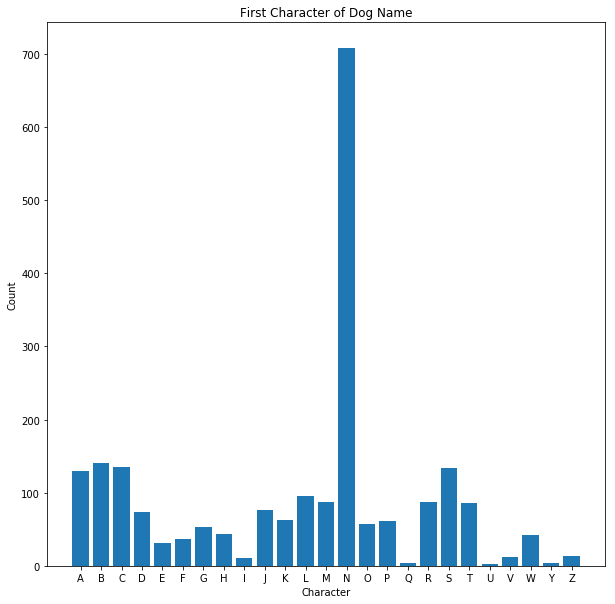

In [701]:
plt.figure(figsize=(10,10))
plt.bar(np.arange(len(first_char_number)),first_char_number)
plt.xticks(np.arange(len(first_char_number)), first_char_number.index);
plt.title('First Character of Dog Name')
plt.xlabel('Character')
plt.ylabel('Count')
plt.savefig('First Character of Dog Name.png')

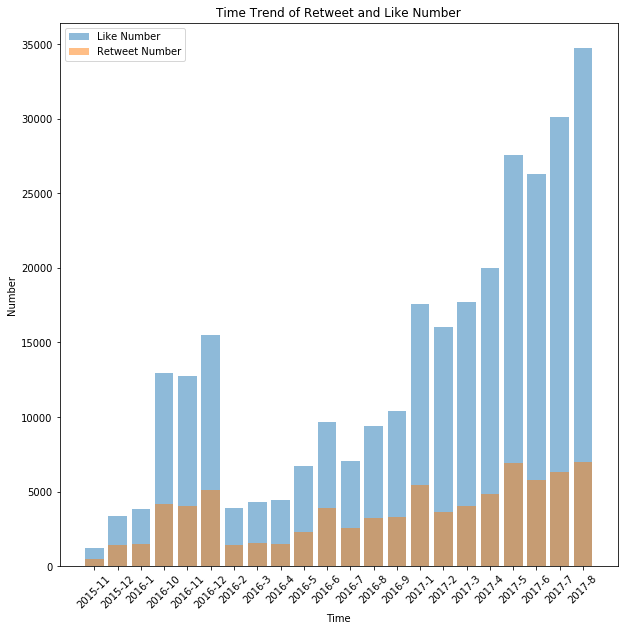

In [702]:
plt.figure(figsize = (10,10))
plt.bar(df_time.index,df_time.like_count,label ='Like Number',alpha = 0.5)
plt.bar(df_time.index,df_time.retweet_count,label = 'Retweet Number',alpha =0.5)
plt.legend()
plt.xticks(rotation=45)
plt.title('Time Trend of Retweet and Like Number')
plt.xlabel('Time')
plt.ylabel('Number')
plt.savefig('Time Trend of Retweet and Like Number.png')

In [493]:
df_dog = pd.DataFrame([df.groupby('dog_type').retweet_count.mean(),df.groupby('dog_type').like_count.mean()])
df_dog = df_dog.transpose()
print('There are',df_dog.shape[0],'dog types in our archive Tweeter data.')

There are 111 dog types in our archive Tweeter data.


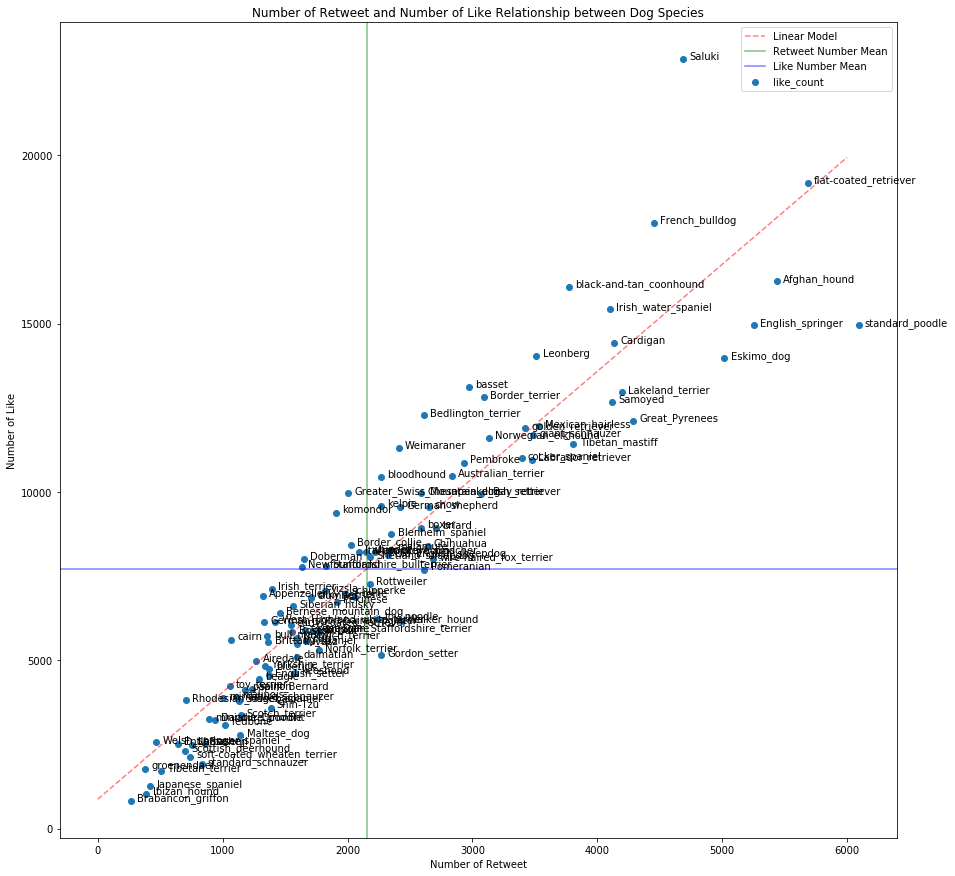

In [704]:
plt.figure(figsize=(15,15))
plt.scatter(df_dog.retweet_count,df_dog.like_count)
regr = linear_model.LinearRegression()
x_pre = np.array(df_dog.retweet_count)
y_pre = np.array(df_dog.like_count)
x_pre = x_pre.reshape(len(x_pre),1)
y_pre = y_pre.reshape(len(y_pre),1)

regr.fit(x_pre,y_pre)
x = np.arange(0,6500,500)
x = x.reshape(len(x),1)
y = regr.predict(x)
plt.plot(x,y,'r--',alpha = 0.5, label = 'Linear Model')
for i in range(len(df_dog.retweet_count)):
    plt.annotate(df_dog.index[i],(df_dog.retweet_count[i]+50,df_dog.like_count[i]+2))
plt.title('Number of Retweet and Number of Like Relationship between Dog Species')
plt.ylabel('Number of Like')
plt.xlabel('Number of Retweet')

plt.axvline(df_dog.retweet_count.mean(),c='g',linewidth = 1.5,alpha = 0.5,label = 'Retweet Number Mean')
plt.axhline(df_dog.like_count.mean(),c='b',linewidth = 1.5,alpha = 0.5, label = 'Like Number Mean')
plt.legend()
plt.savefig('Number of Retweet and Number of Like Relationship between Dog Species.png')